In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import cmath
import pandas as pd
import warnings
from statistics import mean
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [15, 7]
# # from moving_average import moving_avg  # following imports are marked as a mistake, but actually it works
# from exp_avg_and_fourier import exp_avg

In [2]:
# test 1
# my_d = [math.sin(h*i) for i in range(sample_size)]

# test 2
# my_d = [1.1387, 1.09506, 1.04571, 0.991055]
# p = 2
# sample_size = 4

In [3]:
h = 0.02
sample_size = 500
dt = 1  # period of discretization
p = 100  # Prony param: depth of the model (Prony occasionally doesn't work with some values)

my_d = \
    [sum([k*math.exp(-h*i / k) * math.cos(4*math.pi*k*h*i + math.pi/k) for k in range(1, 4)]) for i in range(sample_size)]

Prony Method.
Makes an interpolation by given values (in my_d). Moreover, dumping complex exponents are treated as base functions in this interpolation. Thus, as an output we have a spectrum analysis and interpolation simultaneously (as a spectrum analysis output we obtain amplitudes, frequencies and phases of the given exponents).
Theory:

http://www.techstages.ru/setons-971-1.html

In [4]:
def get_prony_params(distribution, p_param, dt_param):
    d_size = len(distribution)
    x_left = np.array([[distribution[p_param-i+j-1] for i in range(p_param)] for j in range(d_size - p_param)])
    x_right = np.array([-distribution[p_param+j] for j in range(d_size - p_param)])
    a_vector = np.linalg.solve(x_left.T.dot(x_left), x_left.T.dot(x_right))
    z_vector = np.roots(np.append(1, a_vector))

    # frequencies:
    f_vector = [1 / (2 * math.pi * dt) * math.atan(z_vector[i].imag / z_vector[i].real) for i in range(p_param)]

    # dumping param:
    alfa_vector = [1 / dt * math.log(abs(z_vector[i])) for i in range(p_param)]

    # h values:
    z_left = np.array([[z_vector[i] ** j for i in range(p_param)]for j in range(d_size)])
    h_vector = np.linalg.solve(z_left.T.dot(z_left), z_left.T.dot(distribution))

    # amplitude:
    A_vector = [abs(h_vector[k]) for k in range(p_param)]

    # phase:
    phi_vector = [math.atan(h_vector[i].imag / h_vector[i].real) for i in range(p_param)]

    # resulting values
    x_out = [sum([A_vector[k-1] *
              cmath.exp(complex(0,1) * phi_vector[k-1]) *
              cmath.exp((alfa_vector[k-1] + complex(0,1) * math.pi * 2 * f_vector[k-1]) *
                        dt_param * n)
              for k in range(1, p_param+1)]) for n in range(d_size)]

    return x_out, f_vector, A_vector, phi_vector, alfa_vector

Link for final formula (x_out):

https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-018-2473-y#Tab1

In [5]:
x_out, f_vector, A_vector, phi_vector, alfa_vector = get_prony_params(my_d, p, dt)

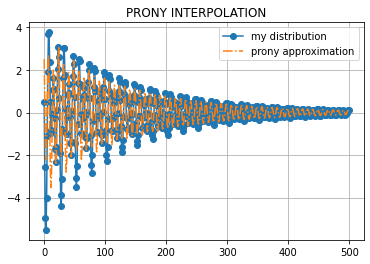

In [6]:
plt.plot(range(sample_size), my_d, marker="o",  label='my distribution')
plt.plot(range(sample_size), x_out, '-.',  label='prony approximation')
plt.title('PRONY INTERPOLATION')
plt.grid()
plt.legend()

In [7]:
graph_setting = max(map(abs, f_vector))
# plt.bar(f_vector, A_vector, width=graph_setting / 75, color='orange')
# plt.xlim(0, 1.2*graph_setting)
# plt.grid()
# plt.legend('PRONY SPECTRUM ANALYSIS')

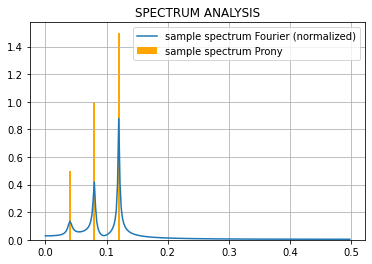

In [8]:
forward = np.fft.fft(my_d)
forward = np.abs(forward[0:len(my_d)//2])
freq = [1/sample_size * k for k in range(sample_size)][0:sample_size//2]

# take the most highlighted bars from Prony method (the most vivid frequencies)
highlighted_bars = [[f_vector[i], A_vector[i]] for i in range (p) if A_vector[i] > mean(A_vector) and f_vector[i] > 0]

plt.grid()
plt.plot(freq, [item / sample_size * 2 for item in forward], label='sample spectrum Fourier (normalized)')
plt.bar([item[0] for item in highlighted_bars], [item[1] for item in highlighted_bars],
        width=graph_setting / 75, color='orange', label='sample spectrum Prony')
plt.title('SPECTRUM ANALYSIS')
plt.legend()

So, we can see, that results of Fourier and Prony methods kind of conicide

Now, lets work with temperature data

In [9]:
df = pd.read_csv('city_temperature.csv',low_memory=False)
df = df.drop_duplicates()
df.head(5)

,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9


In [10]:
def fahrenheit_to_celsius(fahrenheit):
    celsius = (fahrenheit - 32) * 5/9
    return celsius

df_ = df.loc[df['Country'] == 'Russia'].loc[df['Year'].isin([2001, 2002, 2003])].loc[df['City'] == 'Moscow']
df_['AvgTemperature'] = df_['AvgTemperature'].apply(fahrenheit_to_celsius)
df_ = df_
df_.head(5)

,Region,Country,State,City,Month,Day,Year,AvgTemperature
880448,Europe,Russia,NaN,Moscow,1,1,2001,-1.777778
880449,Europe,Russia,NaN,Moscow,1,2,2001,-4.444444
880450,Europe,Russia,NaN,Moscow,1,3,2001,-5.666667
880451,Europe,Russia,NaN,Moscow,1,4,2001,-3.944444
880452,Europe,Russia,NaN,Moscow,1,5,2001,-3.111111


In [11]:
df_ = df_.drop((df_[df_['AvgTemperature'] < -30].index))

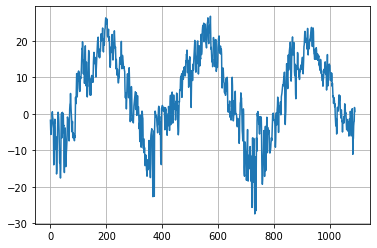

In [12]:
plt.plot(range(len(df_.index)), df_['AvgTemperature'])
plt.grid()

In [13]:
# avg_t = mean(istanbul['AvgTemperature'])
# istanbul['AvgTemperature'] = istanbul['AvgTemperature'].apply(lambda x: avg_t if (x<-40) or (x>50) else x)

In [14]:
def get_exp_mov_averange(y, alpha):
    arr = [(y[0]+y[1])/2] 
    for i in range(1,len(y)):
        new_val = alpha*y[i] + (1-alpha)*arr[i-1]
        arr.append(new_val)
    return arr
    

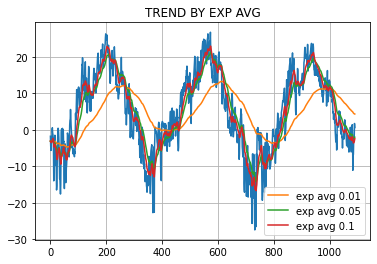

In [15]:
fig = plt.Figure(figsize=(15,10))
plt.plot(range(df_.shape[0]), df_['AvgTemperature'])
plt.plot(range(df_.shape[0]), get_exp_mov_averange(list(df_['AvgTemperature']), 0.01), label='exp avg 0.01')
plt.plot(range(df_.shape[0]), get_exp_mov_averange(list(df_['AvgTemperature']), 0.05), label='exp avg 0.05')
plt.plot(range(df_.shape[0]), get_exp_mov_averange(list(df_['AvgTemperature']), 0.1), label='exp avg 0.1')
plt.title('TREND BY EXP AVG')
plt.grid()
plt.legend()

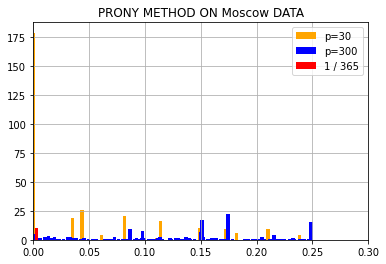

In [16]:
x_out_i1, f_vector_i1, A_vector_i1, phi_vector_i1, alfa_vector_i1 = get_prony_params(list(df_['AvgTemperature']), 30, 1)
x_out_i2, f_vector_i2, A_vector_i2, phi_vector_i2, alfa_vector_i2 = get_prony_params(list(df_['AvgTemperature']), 300, 1)
plt.xlim(0, 0.3)
graph_setting = max(map(abs, f_vector_i1))
plt.bar(f_vector_i1, A_vector_i1, width=graph_setting / 75, color='orange', label='p=30')
plt.bar(f_vector_i2, A_vector_i2, width=graph_setting / 75, color='blue', label='p=300')
plt.bar([1/365], [10], width=graph_setting / 75, color='red', label='1 / 365')
plt.grid()
plt.title('PRONY METHOD ON Moscow DATA')
plt.legend()

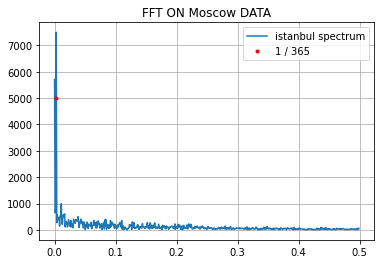

In [17]:
forward = np.fft.fft(list(df_['AvgTemperature']))
forward = np.abs(forward[0:len(list(df_['AvgTemperature']))//2])
freq = [1 / df_.shape[0] * k for k in range(df_.shape[0])][0:df_.shape[0]//2]
plt.plot(freq, forward, label='istanbul spectrum')
plt.plot([1 / 365], [5000], '.', label='1 / 365', color='red')
plt.title('FFT ON Moscow DATA')
plt.legend()
plt.grid()